# CME rate

cme_rate.py
https://github.com/cmoestl/heliocats
analyses ICMECAT data for CME rate

Author: C. Moestl, IWF Graz, Austria
twitter @chrisoutofspace, https://github.com/cmoestl
last update April 2020

For installation of a conda environment to run this code and how to download the data, see instructions in README.md.

Conda dependencies are listed under environment.yml, and pip in requirements.txt.

plots are saved in results/plots_rate/ as png and pdf

ideas:

finish ICMECAT


add RC rate on Figure 1, redo histograms on Fig. 1

add error from ICME rate HSO into fit SSN vs. ICME rate

Figure 3 besser mit punkten schwarz weiss und grau, mit error
errors in histo in HSO rate; poster figures 2019 EGU
t0 problem offenlassen, error in x richtung - PP25 prediction data points mit hathaway! - gibt t0






In [1]:
from scipy import stats
import scipy.io
from matplotlib import cm
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta
import astropy.constants as const
from sunpy.time import parse_time
import sunpy.time
import time
import pickle
import seaborn as sns
import os
import urllib
import json
import warnings
import importlib
import heliopy.spice as spice
import heliopy.data.spice as spicedata
import astropy

#where the 6 in situ data files are located is read from input.py
#as data_path=....
from config import data_path
#reload again while debugging

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

from heliocats import data as hd
importlib.reload(hd) #reload again while debugging


#Convert this notebook to a script with jupyter nbconvert --to script icmecat.ipynb
os.system('jupyter nbconvert --to script cme_statistics.ipynb')    

#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#warnings.filterwarnings('ignore') # some numpy mean-of-empty-slice runtime warnings


########### make directories first time
resdir='results'
if os.path.isdir(resdir) == False: os.mkdir(resdir)

datadir='data'
if os.path.isdir(datadir) == False: os.mkdir(datadir)

outputdirectory='results/plots_rate'
if os.path.isdir(outputdirectory) == False: os.mkdir(outputdirectory)
    
plt.rcParams["figure.figsize"] = (20,10)

## 0. Settings and load data

In [2]:
plt.close('all')

print('cme_rate main program.')
print('Christian Moestl et al., IWF Graz, Austria')

#constants: 
#solar radius
Rs_in_AU=float(const.R_sun/const.au)
#define AU in km
AU_in_km=const.au.value/1e3


#set for loading
load_data=1
get_new_sunspots=0


if load_data > 0:
    
    print('load data (takes a minute or so)')
    print('')
    
    #####################
    print('get RC ICME list')    
    #download richardson and cane list
    rc_url='http://www.srl.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm'

    try: urllib.request.urlretrieve(rc_url,data_path+'rc_list.htm')
    except urllib.error.URLError as e:
        print('Failed downloading ', rc_url,' ',e)

    #read RC list into pandas dataframe    
    rc_dfull=pd.read_html(data_path+'rc_list.htm')
    rc_df=rc_dfull[0]
  

    ##################
    print('get sunspot number from SIDC')    
    #get daily sunspot number from SIDC
    #http://www.sidc.be/silso/datafiles
    #
    #http://www.sidc.be/silso/infosndtot
    #daily sunspot number

    if get_new_sunspots==1:
        ssn=pd.read_csv('data/SN_d_tot_V2.0.csv',sep=';')
        ssn_time=np.zeros(len(ssn))
        for k in np.arange(len(ssn)):
            ssn_time[k]=parse_time(str(ssn.year[k])+'-'+str(ssn.month[k])+'-'+str(ssn.day[k])).plot_date

        print('time convert done')
        ssn.insert(0,'time',ssn_time)
        ssn.spot.loc[np.where(ssn.spot< 0)[0]]=np.nan    
        ssn.spot.loc[np.where(ssn.stand< 0)[0]]=np.nan    
        fileout='ssn.p'
        pickle.dump(ssn, open(data_path+fileout, "wb"))

    file='ssn.p'  
    ssn=pickle.load(open(data_path+file, "rb"))
    
    #make 12 month running mean
    runmean_months=12.0
    ssn_mean_12=hs.running_mean(ssn.spot,int(np.rint(30.42*runmean_months+1)))
    ssn_std_12=hs.running_mean(ssn.stand,int(np.rint(30.42*runmean_months+1)))    

    ssn.insert(1,'spot_mean_12',ssn_mean_12)    
    ssn.insert(2,'spot_std_12',ssn_std_12)    
    
    print('SIDC sunspots done')

    
    ################## Spacecraft
    filemav='maven_2014_2018_removed_smoothed.p'
    [mav,hmav]=pickle.load(open(data_path+filemav, 'rb' ) )

    print('load and merge Wind data HEEQ') 
    #from HELCATS HEEQ until 2018 1 1 + new self-processed data with heliosat and hd.save_wind_data
    filewin="wind_2007_2018_heeq_helcats.p" 
    [win1,hwin1]=pickle.load(open(data_path+filewin, "rb" ) )  
    
    #or use: filewin2="wind_2018_now_heeq.p" 
    filewin2="wind_2018_2019_heeq.p" 
    [win2,hwin2]=pickle.load(open(data_path+filewin2, "rb" ) )  

    #merge Wind old and new data 
    #cut off HELCATS data at end of 2017, win2 begins exactly after this
    win1=win1[np.where(win1.time < parse_time('2018-Jan-01 00:00').datetime)[0]]
    #make array
    win=np.zeros(np.size(win1.time)+np.size(win2.time),dtype=[('time',object),('bx', float),('by', float),\
                ('bz', float),('bt', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float),\
                ('r', float),('lat', float),('lon', float)])   

    #convert to recarray
    win = win.view(np.recarray)  
    win.time=np.hstack((win1.time,win2.time))
    win.bx=np.hstack((win1.bx,win2.bx))
    win.by=np.hstack((win1.by,win2.by))
    win.bz=np.hstack((win1.bz,win2.bz))
    win.bt=np.hstack((win1.bt,win2.bt))
    win.vt=np.hstack((win1.vt,win2.vt))
    win.np=np.hstack((win1.np,win2.np))
    win.tp=np.hstack((win1.tp,win2.tp))
    win.x=np.hstack((win1.x,win2.x))
    win.y=np.hstack((win1.y,win2.y))
    win.z=np.hstack((win1.z,win2.z))
    win.r=np.hstack((win1.r,win2.r))
    win.lon=np.hstack((win1.lon,win2.lon))
    win.lat=np.hstack((win1.lat,win2.lat))

    print('Wind merging done')
    

    filevex='vex_2007_2014_sceq_removed.p'
    [vex,hvex]=pickle.load(open(data_path+filevex, 'rb' ) )
    
    filevex='vex_2007_2014_sceq.p'
    [vexnon,hvexnon]=pickle.load(open(data_path+filevex, 'rb' ) )
    

    filemes='messenger_2007_2015_sceq_removed.p'
    [mes,hmes]=pickle.load(open(data_path+filemes, 'rb' ) )

    filemes='messenger_2007_2015_sceq.p'
    [mesnon,hmesnon]=pickle.load(open(data_path+filemes, 'rb' ) )

 
    filestb='stereob_2007_2014_sceq.p'
    [stb,hstb]=pickle.load(open(data_path+filestb, "rb" ) )      
             
    filesta='stereoa_2007_2019_sceq.p'
    [sta,hsta]=pickle.load(open(data_path+filesta, "rb" ) )  

    filepsp='psp_2018_2019_sceq.p'
    [psp,hpsp]=pickle.load(open(data_path+filepsp, "rb" ) )  
    
    fileuly='ulysses_1990_2009_rtn.p'
    [uly,huly]=pickle.load(open(data_path+fileuly, "rb" ) ) 
    
    fileomni='omni_1963_2020.p'
    [omni,homni]=pickle.load(open(data_path+fileomni, "rb" ) ) 

    print('load all data done')

    
# ############# get positions from a 
# # pre-made IDL sav file for older spacecraft positions
# print()
# print('get positions')
# pos = hs.getcat('data/positions_2007_2023_HEEQ_6hours.sav')
# pos_time= hs.decode_array(pos.time) 
# pos_time_num=parse_time(pos_time).plot_date 
# print('positions done')


########### load ICMECAT v2.0, made with icmecat.py or ipynb
file='icmecat/HELCATS_ICMECAT_v20_pandas.p'
print()
print('loaded ', file)
print()
print('Keys (parameters) in this pandas data frame are:')

[ic,h,p]=pickle.load(open(file, "rb" ) )  
print(ic.keys())
print()

################### get indices of events for each spacecraft

mercury_orbit_insertion_time= parse_time('2011-03-18').datetime

#spacecraft near the 4 terrestrial planets
#get indices for Mercury after orbit insertion in March 2011
merci=np.where(np.logical_and(ic.sc_insitu =='MESSENGER', ic.icme_start_time > mercury_orbit_insertion_time))[0]
vexi=np.where(ic.sc_insitu == 'VEX')[:][0]  
wini=np.where(ic.sc_insitu == 'Wind')[:][0] 
mavi=np.where(ic.sc_insitu == 'MAVEN')[:][0]    

#other spacecraft
#all MESSENGER events including cruise phase
mesi=np.where(ic.sc_insitu == 'MESSENGER')[:][0]   
pspi=np.where(ic.sc_insitu == 'ParkerSolarProbe')[:][0]    
stai=np.where(ic.sc_insitu == 'STEREO-A')[:][0]    
stbi=np.where(ic.sc_insitu == 'STEREO-B')[:][0]    
ulyi=np.where(ic.sc_insitu == 'ULYSSES')[:][0]   

############### set limits of solar minimum, rising/declining phase and solar maximum

# minimim maximum times as given by
#http://www.sidc.be/silso/cyclesmm
#24    2008   12    2.2   2014 04   116.4  

solarmin=parse_time('2008-12-01').datetime
minstart=solarmin-datetime.timedelta(days=366*1.5)
minend=solarmin+datetime.timedelta(days=365)
minstart_num=parse_time(minstart).plot_date
minend_num=parse_time(minend).plot_date

solarmax=parse_time('2014-04-01').datetime
maxstart=solarmax-datetime.timedelta(days=365*3)
maxend=solarmax+datetime.timedelta(days=365/2)
maxstart_num=parse_time(maxstart).plot_date
maxend_num=parse_time(maxend).plot_date


#rising phase not used
# risestart=parse_time('2010-01-01').datetime
# riseend=parse_time('2011-06-30').datetime
# risestart_num=parse_time('2010-01-01').plot_date
# riseend_num=parse_time('2011-06-30').plot_date

# declstart=parse_time('2015-01-01').datetime
# declend=parse_time('2018-12-31').datetime
# declstart_num=parse_time('2015-01-01').plot_date
# declend_num=parse_time('2018-12-31').plot_date


############### extract events by limits of solar minimum and  maximum
iall_min=np.where(np.logical_and(ic.icme_start_time > minstart,ic.icme_start_time < minend))[0]
#iall_rise=np.where(np.logical_and(ic.icme_start_time > risestart,ic.icme_start_time < riseend))[0]
iall_max=np.where(np.logical_and(ic.icme_start_time > maxstart,ic.icme_start_time < maxend))[0]

wini_min=iall_min[np.where(ic.sc_insitu[iall_min]=='Wind')]
#wini_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='Wind')]
wini_max=iall_max[np.where(ic.sc_insitu[iall_max]=='Wind')]

vexi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='VEX')]
#vexi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='VEX')]
vexi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='VEX')]

mesi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='MESSENGER')]
#mesi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='MESSENGER')]
mesi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='MESSENGER')]

stai_min=iall_min[np.where(ic.sc_insitu[iall_min]=='STEREO-A')]
#stai_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='STEREO-A')]
stai_max=iall_max[np.where(ic.sc_insitu[iall_max]=='STEREO-A')]

stbi_min=iall_min[np.where(ic.sc_insitu[iall_min]=='STEREO-B')]
#stbi_rise=iall_rise[np.where(ic.sc_insitu[iall_rise]=='STEREO-B')]
stbi_max=iall_max[np.where(ic.sc_insitu[iall_max]=='STEREO-B')]

# select the events at Mercury extra after orbit insertion, note that no events available for solar minimum
merci_min=iall_min[np.where(np.logical_and(ic.sc_insitu[iall_min] =='MESSENGER',ic.icme_start_time[iall_min] > parse_time('2011-03-18').datetime))]
#merci_rise=iall_rise[np.where(np.logical_and(ic.sc_insitu[iall_rise] =='MESSENGER',ic.icme_start_time[iall_rise] > parse_time('2011-03-18').datetime))]
merci_max=iall_max[np.where(np.logical_and(ic.sc_insitu[iall_max] =='MESSENGER',ic.icme_start_time[iall_max] > parse_time('2011-03-18').datetime))]

print('done')

cme_rate main program.
Christian Moestl et al., IWF Graz, Austria
load data (takes a minute or so)

get RC ICME list
get sunspot number from SIDC
SIDC sunspots done
load and merge Wind data HEEQ
Wind merging done
load all data done

loaded  icmecat/HELCATS_ICMECAT_v20_pandas.p

Keys (parameters) in this pandas data frame are:
Index(['icmecat_id', 'sc_insitu', 'icme_start_time', 'mo_start_time',
       'mo_end_time', 'mo_sc_heliodistance', 'mo_sc_long_heeq',
       'mo_sc_lat_heeq', 'icme_duration', 'icme_bmax', 'icme_bmean',
       'icme_bstd', 'icme_speed_mean', 'icme_speed_std', 'mo_duration',
       'mo_bmax', 'mo_bmean', 'mo_bstd', 'mo_bzmean', 'mo_bzmin', 'mo_bzstd',
       'mo_bymean', 'mo_bystd', 'mo_speed_mean', 'mo_speed_std',
       'mo_expansion_speed', 'mo_pdyn_mean', 'mo_pdyn_std', 'mo_density_mean',
       'mo_density_std', 'mo_temperature_mean', 'mo_temperature_std',
       'sheath_speed_mean', 'sheath_speed_std', 'sheath_density_mean',
       'sheath_density_std', 'shea

In [3]:
ic

,icmecat_id,sc_insitu,icme_start_time,mo_start_time,mo_end_time,mo_sc_heliodistance,mo_sc_long_heeq,mo_sc_lat_heeq,icme_duration,icme_bmax,...,mo_density_mean,mo_density_std,mo_temperature_mean,mo_temperature_std,sheath_speed_mean,sheath_speed_std,sheath_density_mean,sheath_density_std,sheath_pdyn_mean,sheath_pdyn_std
0,ICME_PSP_MOESTL_20181030_01,PSP,2018-10-30 20:25:00,2018-10-30 20:25:00,2018-10-31 08:19:00,0.2645,24.92,0.12,11.90,84.1,...,176.7,30.9,57176.8,17212.1,NaN,NaN,NaN,NaN,NaN,NaN
1,ICME_PSP_MOESTL_20181111_01,PSP,2018-11-11 23:51:00,2018-11-11 23:51:00,2018-11-12 05:59:00,0.2545,178.55,-1.12,6.13,98.9,...,168.5,51.3,73074.1,38992.7,NaN,NaN,NaN,NaN,NaN,NaN
2,ICME_PSP_MOESTL_20190315_01,PSP,2019-03-15 09:00:00,2019-03-15 12:11:00,2019-03-15 17:49:00,0.5465,-161.32,3.17,8.82,33.4,...,30.2,9.0,23399.7,16991.4,397.1,24.4,49.1,10.7,13.1,3.7
3,ICME_PSP_MOESTL_20190324_01,PSP,2019-03-24 03:45:00,2019-03-24 03:45:00,2019-03-24 17:38:00,0.3858,-148.82,2.03,13.88,34.0,...,52.4,10.1,40375.0,17986.7,NaN,NaN,NaN,NaN,NaN,NaN
4,ICME_PSP_MOESTL_20190725_01,PSP,2019-07-25 08:13:00,2019-07-25 08:13:00,2019-07-25 23:06:00,0.7739,49.91,3.89,14.88,13.7,...,19.9,6.8,77095.2,40614.1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,ICME_MAVEN_MOESTL_20170112_01,MAVEN,2017-01-12 08:40:00,2017-01-13 03:00:00,2017-01-13 16:50:00,1.4198,-89.14,4.94,32.17,6.8,...,4.0,1.2,367911.7,50256.0,454.5,26.2,3.6,1.2,1.3,0.5
739,ICME_MAVEN_MOESTL_20170119_01,MAVEN,2017-01-19 05:50:00,2017-01-19 15:00:00,2017-01-20 18:30:00,1.4262,-91.86,4.74,36.67,5.5,...,2.6,0.8,287437.6,242820.6,357.1,9.7,2.8,0.7,0.6,0.2
740,ICME_MAVEN_MOESTL_20170703_01,MAVEN,2017-07-03 22:20:00,2017-07-04 21:00:00,2017-07-06 04:40:00,1.6225,-168.71,-2.80,54.33,7.8,...,4.8,1.4,369548.7,456549.3,378.7,6.1,2.6,1.2,0.6,0.3
741,ICME_MAVEN_MOESTL_20170722_01,MAVEN,2017-07-22 14:30:00,2017-07-22 14:30:00,2017-07-24 11:50:00,1.6368,-177.51,-3.47,45.33,6.7,...,4.8,1.4,178292.6,220041.6,NaN,NaN,NaN,NaN,NaN,NaN


## 1.  ICME rate for solar cycles 23/24 from the Heliophysics System Observatory

### Check data days available each year for each planet or spacecraft

In [17]:
#make bin for each year for yearly histograms
#define dates of January 1 from 2007 to end year

last_year=2019 #2020 means last date is 2019 Dec 31

years_jan_1_str=[str(i)+'-01-01' for i in np.arange(2007,last_year) ] 
yearly_start_times=parse_time(years_jan_1_str).datetime
yearly_start_times_num=parse_time(years_jan_1_str).plot_date

#same for July 1 as middle of the year
years_jul_1_str=[str(i)+'-07-01' for i in np.arange(2007,last_year) ] 
yearly_mid_times=parse_time(years_jul_1_str).datetime
yearly_mid_times_num=parse_time(years_jul_1_str).plot_date

#same for december 31
years_dec_31_str=[str(i)+'-12-31' for i in np.arange(2007,last_year) ] 
yearly_end_times=parse_time(years_dec_31_str).datetime
yearly_end_times_num=parse_time(years_dec_31_str).plot_date


#define arrays for total data days and fill with nan
total_data_days_yearly_win=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_win.fill(np.nan)

total_data_days_yearly_sta=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_sta.fill(np.nan)

total_data_days_yearly_stb=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_stb.fill(np.nan)

total_data_days_yearly_mes=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_mes.fill(np.nan)

total_data_days_yearly_merc=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_merc.fill(np.nan)

total_data_days_yearly_vex=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_vex.fill(np.nan)

total_data_days_yearly_mav=np.zeros(np.size(yearly_mid_times))
total_data_days_yearly_mav.fill(np.nan)


#go through each year and search for available data
#time is available for all dates, so no NaNs in time
#search for all not NaNs in Btotal variable

#go through all years
for i in range(np.size(yearly_mid_times)):
    
  print(yearly_start_times[i])

  #get indices of Wind time for the current year
  thisyear=np.where(np.logical_and((win.time > yearly_start_times[i]),(win.time < yearly_end_times[i])))[0]
  #get np.size of available data for each year
  datas=np.size(np.where(np.isnan(win.bt[thisyear])==False))
  #wind is  in 1 minute resolution
  min_in_days=1/(60*24)
  #calculate available days from number of datapoints (each 1 minute) 
  #divided by number of minutes in 1 days
  #this should only be the case if data is available this year, otherwise set to NaN
  if datas >0: total_data_days_yearly_win[i]=datas*min_in_days

  #same for STEREO-A
  thisyear=np.where(np.logical_and((sta.time > yearly_start_times[i]),(sta.time < yearly_end_times[i])))[0]
  datas=np.size(np.where(np.isnan(sta.bt[thisyear])==False))
  if datas >0: total_data_days_yearly_sta[i]=datas*min_in_days

  #same for STEREO-B
  thisyear=np.where(np.logical_and((stb.time > yearly_start_times[i]),(stb.time < yearly_end_times[i])))[0]
  datas=np.size(np.where(np.isnan(stb.bt[thisyear])==False))
  if datas >0: total_data_days_yearly_stb[i]=datas*min_in_days

  #same for MESSENGER
  #thisyear=np.where(np.logical_and((mes.time > yearly_start_times_d[i]),(mes.time < yearly_end_times_d[i])))
  #datas=np.size(np.where(np.isnan(mes.bt[thisyear])==False))
  #if datas >0: total_data_days_yearly_mes[i]=datas*min_in_days

  #same for Mercury alone with non-removed dataset
  #start with 2011
  if i == 4: 
   thisyear=np.where(np.logical_and((mesnon.time > mercury_orbit_insertion_time),(mesnon.time < yearly_end_times[i])))[0]
   datas=np.size(np.where(np.isnan(mesnon.bt[thisyear])==False))
   if datas >0: total_data_days_yearly_merc[i]=datas*min_in_days
  #2012 onwards 
  if i > 4: 
   thisyear=np.where(np.logical_and((mesnon.time > yearly_start_times[i]),(mesnon.time < yearly_end_times[i])))
   datas=np.size(np.where(np.isnan(mesnon.bt[thisyear])==False))
   if datas >0: total_data_days_yearly_merc[i]=datas*min_in_days
      

  #same for VEX
  thisyear=np.where(np.logical_and((vexnon.time > yearly_start_times[i]),(vexnon.time < yearly_end_times[i])))[0]
  datas=np.size(np.where(np.isnan(vexnon.bt[thisyear])==False))
  if datas >0: total_data_days_yearly_vex[i]=datas*min_in_days

  #for MAVEN different time resolution
  thisyear=np.where(np.logical_and((mav.time > yearly_start_times[i]),(mav.time < yearly_end_times[i])))[0]
  datas=np.size(np.where(np.isnan(mav.bt[thisyear])==False))
  datas_ind=np.where(np.isnan(mav.bt[thisyear])==False)
  #sum all time intervals for existing data points, but avoid counting gaps where diff is > 1 orbit (0.25 days)
  alldiff=np.diff(parse_time(mav.time[datas_ind]).plot_date)
  smalldiff_ind=np.where(alldiff <0.25)  
  if datas >0: total_data_days_yearly_mav[i]=np.sum(alldiff[smalldiff_ind])

print('Data days each year:')

print()

print('MESSENGER at Mercury')
print(np.round(total_data_days_yearly_merc,1))
#print('MES')
#print(np.round(total_data_days_yearly_mes,1))
print('VEX at Venus')
print(np.round(total_data_days_yearly_vex,1))

print()
print('Earth and solar wind')
print('Wind')

#********************* manual override because Wind data for 2018 are heavily despiked
total_data_days_yearly_win[-1]=360

print(np.round(total_data_days_yearly_win,1))
print('STA')
print(np.round(total_data_days_yearly_sta,1))
print('STB')
print(np.round(total_data_days_yearly_stb,1))
print()


print('MAVEN at Mars')
print(np.round(total_data_days_yearly_mav,1))

print('done')



2007-01-01 00:00:00
2008-01-01 00:00:00
2009-01-01 00:00:00
2010-01-01 00:00:00
2011-01-01 00:00:00
2012-01-01 00:00:00
2013-01-01 00:00:00
2014-01-01 00:00:00
2015-01-01 00:00:00
2016-01-01 00:00:00
2017-01-01 00:00:00
2018-01-01 00:00:00
Data days each year:

MESSENGER at Mercury
[  nan   nan   nan   nan 203.8 227.8 194.1 358.  117.1   nan   nan   nan]
VEX at Venus
[340.5 326.6 336.4 315.7 316.4 328.5 317.4 264.    nan   nan   nan   nan]

Earth and solar wind
Wind
[356.5 357.7 352.5 354.  353.5 355.8 355.7 329.5 351.2 359.6 360.8 360. ]
STA
[361.  361.9 361.1 356.  357.6 356.5 353.6 238.1 233.7 363.1 333.3 322.2]
STB
[361.3 364.1 361.2 345.1 351.  355.5 356.5 261.5   nan   nan   nan   nan]

MAVEN at Mars
[  nan   nan   nan   nan   nan   nan   nan  36.5 225.1 260.1 181.9   nan]
done


### get Richardson and Cane ICME rate for comparison


[ 4 22 36 33 51 48 26 22 21 31 13  2  3 11 15 32 35 25 20 30 13  9  8  5]
[1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007.
 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019.]


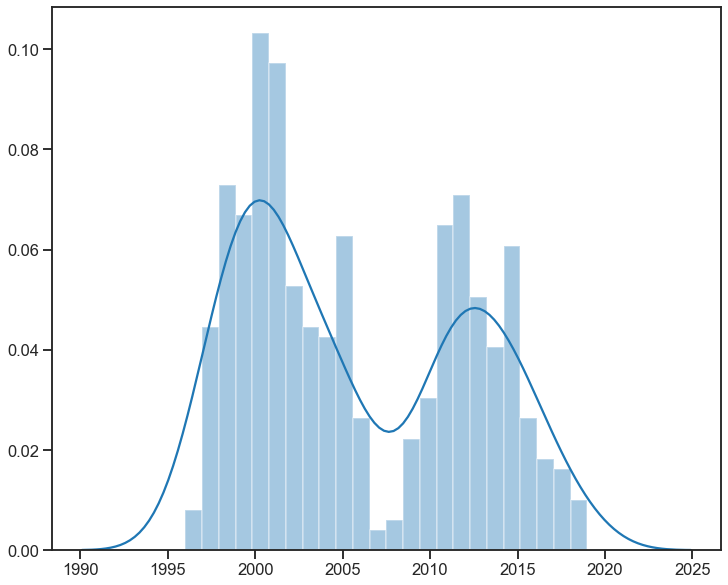

In [18]:
#convert dataframe from richardson and cane list to numpy array
r1=np.array(rc_df['Disturbance Y/M/D (UT) (a)'])

#get ICME rate, go through all rows

rc_year=np.zeros(len(r1))

#go through all rows, extract string and check whether its a viable flot and non nan:
for p in np.arange(0,len(r1)):    
    rc_yearstr=str(r1[p,0])    
    if hs.is_float(rc_yearstr[0:4]):
        if np.isfinite(float(rc_yearstr[0:4])):
            rc_year[p]=float(rc_yearstr[0:4])

rc_year.sort() 
rc_icme_per_year=np.trim_zeros(rc_year)
#print(rc_year)


#quick check whats in this array
fig=plt.figure(11,figsize=(12,10	))
ax11=sns.distplot(rc_icme_per_year,bins=24)

#get yearly ICME rate (use range to get correct numbers)
rc_rate_values=np.histogram(rc_icme_per_year,bins=24,range=(1996,2020))[0]
#cutoff 2020
rc_rate_time=np.histogram(rc_icme_per_year,bins=24,range=(1996,2020))[1][0:-1]

print(rc_rate_values)
print(rc_rate_time)



### **Figure 1** plot ICME frequency cycle 24

for solar min 2007-2009 average ICME per year rate:
nan
for 2012 2013 2014
26.449518309260643


/Users/chris/anaconda3/envs/helio/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: Mean of empty slice


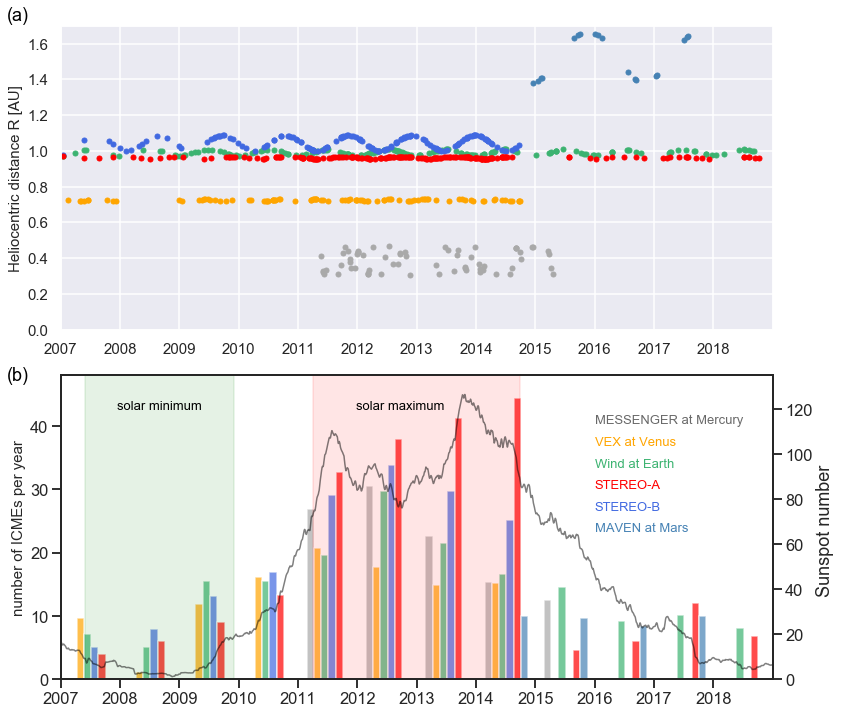

In [19]:
#define dates of January 1 from 2007 to 2017
years_jan_1_str=[str(i)+'-01-01' for i in np.arange(2007,last_year+1) ] 
yearly_bin_edges=parse_time(years_jan_1_str).plot_date
#bin width in days         
binweite=360/8

sns.set_context("talk")     
sns.set_style('darkgrid')
fsize=15

fig=plt.figure(1,figsize=(12,10	))

######################## Fig 1a
ax1 = plt.subplot(211) 
plt.plot_date(ic.icme_start_time[merci],ic.mo_sc_heliodistance[merci],fmt='o',color='darkgrey',markersize=5)
plt.plot_date(ic.icme_start_time[vexi],ic.mo_sc_heliodistance[vexi],fmt='o',color='orange',markersize=5)

plt.plot_date(ic.icme_start_time[wini],ic.mo_sc_heliodistance[wini],fmt='o',color='mediumseagreen',markersize=5)
plt.plot_date(ic.icme_start_time[mavi],ic.mo_sc_heliodistance[mavi],fmt='o',color='steelblue',markersize=5)

plt.plot_date(ic.icme_start_time[stbi],ic.mo_sc_heliodistance[stbi],fmt='o',color='royalblue',markersize=5)
plt.plot_date(ic.icme_start_time[stai],ic.mo_sc_heliodistance[stai],fmt='o',color='red',markersize=5)
#plt.plot_date(ic.icme_start_time[ulyi],ic.mo_sc_heliodistance[ulyi],fmt='o',color='brown',markersize=5)

plt.ylabel('Heliocentric distance R [AU]',fontsize=fsize)
#plt.xlabel('Year',fontsize=fsize)
plt.yticks(np.arange(0,2.0,0.2),fontsize=fsize) 
plt.xticks(yearly_start_times,fontsize=fsize) 

plt.xlim(yearly_bin_edges[0],yearly_bin_edges[-1])
plt.ylim([0,1.7])

ax1.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_formatter(myformat)


sns.set_style('white')
sns.set_style("ticks",{'grid.linestyle': '--'})



#################### Fig 1b
(histmerc, bin_edgesmerc) = np.histogram(mdates.date2num(ic.icme_start_time[merci]), yearly_bin_edges)
(histvex, bin_edgesvex) = np.histogram(mdates.date2num(ic.icme_start_time[vexi]), yearly_bin_edges)
(histwin, bin_edgeswin) = np.histogram(mdates.date2num(ic.icme_start_time[wini]), yearly_bin_edges)
(histmav, bin_edgesmav) = np.histogram(mdates.date2num(ic.icme_start_time[mavi]), yearly_bin_edges)

(histstb, bin_edgesstb) = np.histogram(mdates.date2num(ic.icme_start_time[stbi]), yearly_bin_edges)
(histsta, bin_edgessta) = np.histogram(mdates.date2num(ic.icme_start_time[stai]), yearly_bin_edges)

#normalize each dataset for data gaps

#*** check longer gaps at VEX and Mercury; otherwise these data arise from the bow shock gaps for each orbit
histvex=histvex/total_data_days_yearly_vex*365.24
histmerc=histmerc/total_data_days_yearly_merc*365.24

#ok for these spacecraft as continously in the solar wind and the MAVEN data set is without orbit gaps
histsta=histsta/total_data_days_yearly_sta*365.24
histstb=histstb/total_data_days_yearly_stb*365.24
histwin=histwin/total_data_days_yearly_win*365.24
histmav=histmav/total_data_days_yearly_mav*365.24

binedges=bin_edgeswin
#pickle.dump([binedges,histwin,histvex,histmes,histsta,histstb,histmav], \
#             open( "data/icme_frequency.p", "wb" ), protocol=2 )
#[binedges,histwin,histvex,histmes,histsta,histstb,histmav]=pickle.load( open( "plots_stats/stats/icme_frequency.p", "rb" ) )




ax2 = plt.subplot(212) 


#plot sunspot number  with y axis extra on the right

#cut off omni data
otime=omni[-130000:].time
#make 12 month running mean for the hourly data
ospots=hs.running_mean(omni[-130000:].spot,24*30*6+1)
ax3=ax2.twinx()
ax3.plot(otime,ospots,'-k',alpha=0.5,linewidth=1.5)
ax3.set_ylabel('Sunspot number ')
ax3.set_ylim(0,135)



#binweite=45
ax2.bar(bin_edgesmerc[:-1]+30+binweite,histmerc, width=binweite,color='darkgrey', alpha=0.7)
ax2.bar(bin_edgesvex[:-1]+30+binweite*2,histvex, width=binweite,color='orange', alpha=0.7)
ax2.bar(bin_edgeswin[:-1]+30+binweite*3,histwin, width=binweite,color='mediumseagreen', alpha=0.7)
ax2.bar(bin_edgesstb[:-1]+30+binweite*4,histstb, width=binweite,color='royalblue', alpha=0.7)
ax2.bar(bin_edgessta[:-1]+30+binweite*5,histsta, width=binweite,color='red', alpha=0.7)
#ax2.bar(bin_edgessta[:-1]+30+binweite*5,histuly, width=binweite,color='brown', alpha=0.5)
ax2.bar(bin_edgesmav[:-1]+30+binweite*6,histmav, width=binweite,color='steelblue', alpha=0.7)
ax2.set_ylim(0,48)
ax2.set_xlim(yearly_bin_edges[0],yearly_bin_edges[-1])

fsize=15
ax2.set_ylabel('number of ICMEs per year',fontsize=fsize)
#ax2.set_yticks(fontsize=fsize) 




ax2.xaxis_date()
myformat = mdates.DateFormatter('%Y')
ax2.xaxis.set_major_formatter(myformat)
plt.xticks(yearly_start_times, fontsize=fsize) 
plt.xlabel('Year',fontsize=fsize)



#sets planet / spacecraft labels
xoff=0.7 
yoff=0.45
fsize=13
plt.figtext(xoff,yoff-0.03*1,'MESSENGER at Mercury',color='dimgrey', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*2,'VEX at Venus',color='orange', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*3,'Wind at Earth',color='mediumseagreen', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*4,'STEREO-A',color='red', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*5,'STEREO-B',color='royalblue', fontsize=fsize, ha='left')
#plt.figtext(xoff,yoff-0.03*5,'Ulysses',color='brown', fontsize=fsize, ha='left')
plt.figtext(xoff,yoff-0.03*6,'MAVEN at Mars',color='steelblue', fontsize=fsize, ha='left')
#panel labels
plt.figtext(0.02,0.98,'(a)',color='black', fontsize=fsize+5, ha='left')
plt.figtext(0.02,0.48,'(b)',color='black', fontsize=fsize+5, ha='left')
#limits solar min/rise/max
vlevel=120
fsize=13

plt.axvspan(minstart_num,minend_num, color='green', alpha=0.1)
plt.annotate('solar minimum',xy=(minstart_num+(minend_num-minstart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)

plt.axvspan(maxstart_num,maxend_num, color='red', alpha=0.1)
plt.annotate('solar maximum',xy=(maxstart_num+(maxend_num-maxstart_num)/2-100,vlevel),color='black', ha='center', fontsize=fsize)


#plt.axvspan(risestart_num,riseend_num, color='yellow', alpha=0.1)
#plt.annotate('rising phase',xy=(risestart_num+(riseend_num-risestart_num)/2,vlevel),color='black', ha='center', fontsize=fsize)

plt.tight_layout()

#sns.despine()

plt.savefig('results/plots_rate/fig1_icme_rate_hso.pdf', dpi=300)
plt.savefig('results/plots_rate/fig1_icme_rate_hso.png', dpi=300)


##calculate general parameters

print('for solar min 2007-2009 average ICME per year rate:')
mean07=np.mean([histwin[0],histvex[0],histsta[0],histstb[0],histmerc[0]])
mean08=np.mean([histwin[1],histvex[1],histsta[1],histstb[1],histmerc[1]])
mean09=np.mean([histwin[2],histvex[2],histsta[2],histstb[2],histmerc[2]])
print(np.nanmean([mean07,mean08,mean09]))

#print('for 2010 2011')
#mean10=np.mean([histwin[3],histvex[3],histsta[3],histstb[3],histmes[3]])
#mean11=np.mean([histwin[4],histvex[4],histsta[4],histstb[4],histmes[4]])
#print(np.mean([mean10,mean11]))


print('for 2012 2013 2014')
mean12=np.mean([histwin[5],histvex[5],histsta[5],histstb[5],histmerc[5]])
mean13=np.mean([histwin[6],histvex[6],histsta[6],histstb[6],histmerc[6]])
mean14=np.mean([histwin[7],histvex[7],histsta[7],histstb[7],histmerc[7]])

print(np.mean([mean12,mean13,mean14]))



# 2 get solar cycle results on ICME rates and sunspot numbers

## solar cycle 23

In [20]:
print('cycle 23\n')


############################# times
print('times:')
#these years cover solar cycle 23
years23=np.arange(1996,2009)
print(years23)

last_year=years23[-1] 

years_jan_1_str_23=[str(i)+'-01-01' for i in np.arange(1996,last_year+1) ] 
yearly_start_times_23=parse_time(years_jan_1_str_23).datetime
yearly_start_times_num_23=parse_time(years_jan_1_str_23).plot_date

#same for July 1 as middle of the year
years_jul_1_str_23=[str(i)+'-07-01' for i in np.arange(1996,last_year+1) ] 
yearly_mid_times_23=parse_time(years_jul_1_str_23).datetime
yearly_mid_times_num_23=parse_time(years_jul_1_str_23).plot_date


print(yearly_mid_times_23)

#same for december 31
years_dec_31_str_23=[str(i)+'-12-31' for i in np.arange(1996,last_year+1) ] 
yearly_end_times_23=parse_time(years_dec_31_str_23).datetime
yearly_end_times_num_23=parse_time(years_dec_31_str_23).plot_date


# minimim maximum times as given by
#http://www.sidc.be/silso/cyclesmm
#1996   08   11.2   2001 11  180.3   12  04

solarmin23=parse_time('1996-08-01').datetime
# minstart_23=solarmin_23-datetime.timedelta(days=366*1.5)
# minend=solarmin+datetime.timedelta(days=365)
# minstart_num=parse_time(minstart).plot_date
# minend_num=parse_time(minend).plot_date

solarmax23=parse_time('2001-11-01').datetime
# maxstart=solarmax-datetime.timedelta(days=365*3)
# maxend=solarmax+datetime.timedelta(days=365/2)
# maxstart_num=parse_time(maxstart).plot_date
# maxend_num=parse_time(maxend).plot_date

print('min/max',solarmin23,solarmax23)
print()


#################### spots 
#get yearly smoothed 12 month spot rate 

spots23=np.zeros(len(years23))
counter=0
for q in years23:
    spots23[counter]=np.mean(ssn.spot[np.where(ssn.year==q)[0] ] )
    counter=counter+1

print('spots:')
print('spots yearly mean', np.rint(spots23))
print()


#################### ICME rate
#number of MFR events in Wind ICME catalog, 
#for years as in yearly_mid_times_23 but start aug 1996 and end with 
#nov 2008 #note : halloween events at ACE! Wind not?
wind_mfr_number_23=[2,8,29,11,30,21,20,6,12,16,13,7,3]
#wind_mfr_number_23_err=[2,8,29,11,30,21,20,6,12,16,13,7,3]

#***make better with exact minimum dates!! not per year
rc_rate23=rc_rate_values[0:13]


print('icme rate:')
print('icmes RC',rc_rate23)
print()

cycle 23

times:
[1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008]
[datetime.datetime(1996, 7, 1, 0, 0) datetime.datetime(1997, 7, 1, 0, 0)
 datetime.datetime(1998, 7, 1, 0, 0) datetime.datetime(1999, 7, 1, 0, 0)
 datetime.datetime(2000, 7, 1, 0, 0) datetime.datetime(2001, 7, 1, 0, 0)
 datetime.datetime(2002, 7, 1, 0, 0) datetime.datetime(2003, 7, 1, 0, 0)
 datetime.datetime(2004, 7, 1, 0, 0) datetime.datetime(2005, 7, 1, 0, 0)
 datetime.datetime(2006, 7, 1, 0, 0) datetime.datetime(2007, 7, 1, 0, 0)
 datetime.datetime(2008, 7, 1, 0, 0)]
min/max 1996-08-01 00:00:00 2001-11-01 00:00:00

spots:
spots yearly mean [ 12.  29.  88. 136. 174. 170. 164.  99.  65.  46.  25.  13.   4.]

icme rate:
icmes RC [ 4 22 36 33 51 48 26 22 21 31 13  2  3]



## solar cycle 24

In [21]:
print('cycle 24\n')

#################### times
print('times:')
#these years cover solar cycle 23
years24=np.arange(2009,2020)
print(years24)

#same for July 1 as middle of the year
last_year=2020
years_jul_1_str_24=[str(i)+'-07-01' for i in np.arange(2009,last_year) ] 
yearly_mid_times_24=parse_time(years_jul_1_str_24).datetime
yearly_mid_times_num_24=parse_time(years_jul_1_str_24).plot_date
print(yearly_mid_times_24)
print()


#################### spots 
print('spots:')

#get yearly smoothed 12 month spot rate 
spots24=np.zeros(len(years24))
counter=0
for q in years24:
    spots24[counter]=np.mean(ssn.spot[np.where(ssn.year==q)[0] ] )
    counter=counter+1

print('spots yearly mean:', np.rint(spots24))
print()


################# ICME rate
print('icme rate:')
wind_mfr_number_24=histwin
print('icmes from HSO',np.rint(histwin))
print('***errors!! times to 2019')

rc_rate24=rc_rate_values[13:]
print('icmes RC',rc_rate24)
print()

cycle 24

times:
[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
[datetime.datetime(2009, 7, 1, 0, 0) datetime.datetime(2010, 7, 1, 0, 0)
 datetime.datetime(2011, 7, 1, 0, 0) datetime.datetime(2012, 7, 1, 0, 0)
 datetime.datetime(2013, 7, 1, 0, 0) datetime.datetime(2014, 7, 1, 0, 0)
 datetime.datetime(2015, 7, 1, 0, 0) datetime.datetime(2016, 7, 1, 0, 0)
 datetime.datetime(2017, 7, 1, 0, 0) datetime.datetime(2018, 7, 1, 0, 0)
 datetime.datetime(2019, 7, 1, 0, 0)]

spots:
spots yearly mean: [  5.  25.  81.  85.  94. 113.  70.  40.  22.   7.   4.]

icme rate:
icmes from HSO [ 7.  5. 16. 15. 20. 30. 22. 17. 15.  9. 10.  8.]
***errors!! times to 2019
icmes RC [11 15 32 35 25 20 30 13  9  8  5]



## **Figure 2** make histogram of spots yearly to correlate with ICME rate
plot SSN vs ICME rate, linear fit with confidence interval



linear fit SSN vs. ICME rate
LinregressResult(slope=0.20896856839851677, intercept=7.795659965015293, rvalue=0.8437296411023043, pvalue=2.2276281857119034e-07, stderr=0.028343484728813165)
icme_rate[per year] = ( 0.209 +/- 0.028 ) * sunspot number [yearly] +  7.796
inverse slope: 4.79
Pearson correlation coefficient: 0.84
mean difference icme rate SC23 to predicted rate with linear fit, over full cycle: 0.27 +/- 8.2
mean difference icme rate SC24 to predicted rate with linear fit, over full cycle: -0.32 +/- 5.9

*************** add on ICME rate spread from HSO observations


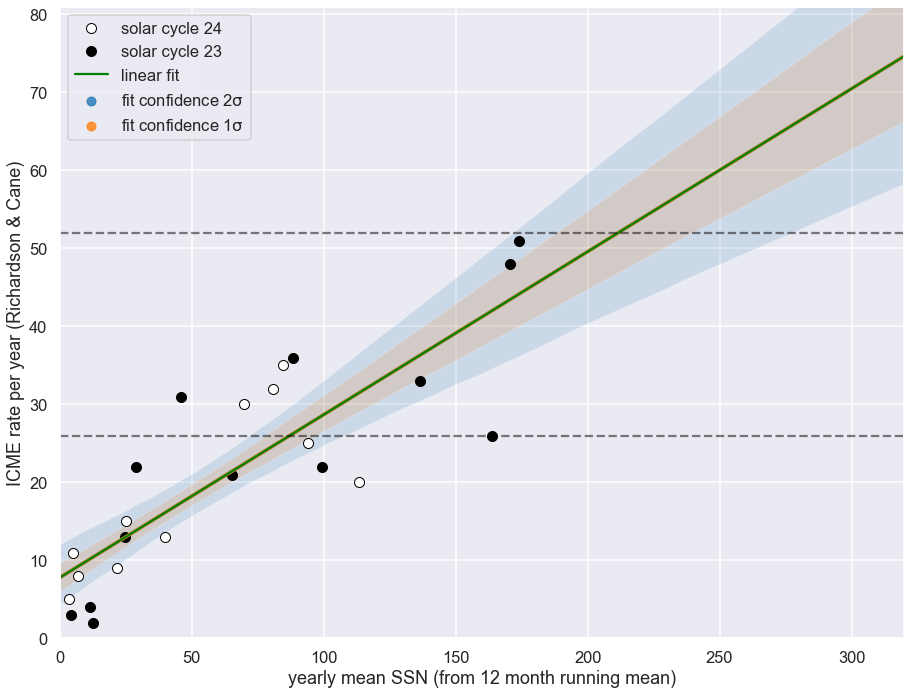

In [33]:
#add spots23/24 and rc_rate23/24 into 1 array for correlation
spots_corr=np.hstack([spots23,spots24])
rc_rate_corr=np.hstack([rc_rate23,rc_rate24])

#quick check with seaborn for correlation
#seaborn uses this :import statsmodels
#kind{ “scatter” | “reg” | “resid” | “kde” | “hex” }, optional
#sns.jointplot(spots_corr,rc_rate_corr,kind='reg',xlim=[0,np.max(spots_corr)+20],ylim=[0,np.max(rc_rate_corr+10)], \
#                  marginal_kws=dict(bins=5, rug=True),x_ci=95).set_axis_labels("yearly mean SSN (12 month running mean)", "ICME rate (Richardson & Cane)")


##################################### make linear fit

#************ add errors in ICME rate here
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
print('linear fit SSN vs. ICME rate')
linfit=scipy.stats.linregress(spots_corr,rc_rate_corr)
print(linfit)
print('icme_rate[per year] = (',np.round(linfit.slope,3),'+/-',np.round(linfit.stderr,3),') * sunspot number [yearly] + ',np.round(linfit.intercept,3))


print('inverse slope:',np.round(1/linfit.slope,2))
print('Pearson correlation coefficient:',np.round(linfit.rvalue,2))


#################################### Function for conversion, with errors on fit confidence 2 times std
 
#with these results from the linear fit, make a conversion function from ssn to icme_rate
def ssn_to_rate(ssn,fitresult):    
    rate=linfit.slope*ssn+linfit.intercept    
    rate_low=(linfit.slope-2*linfit.stderr)*ssn+linfit.intercept    
    rate_up=(linfit.slope+2*linfit.stderr)*ssn+linfit.intercept    
    return rate, rate_low, rate_up

print('mean difference icme rate SC23 to predicted rate with linear fit, over full cycle:',  \
      np.round(np.mean(ssn_to_rate(spots23,linfit)[0]-rc_rate23),2),'+/-', \
      np.round(np.std(ssn_to_rate(spots23,linfit)[0]-rc_rate23),1))#
print('mean difference icme rate SC24 to predicted rate with linear fit, over full cycle:',  \
      np.round(np.mean(ssn_to_rate(spots24,linfit)[0]-rc_rate24),2),'+/-', \
      np.round(np.std(ssn_to_rate(spots24,linfit)[0]-rc_rate24),1))#
print()


############################ plot figure
sns.set_context("talk")     
sns.set_style('darkgrid')
fsize=15
fig=plt.figure(2,figsize=(13,10))
#plt.plot(spots_corr,rc_rate_corr,marker='o',linestyle='',markersize=10)
plt.plot(spots24,rc_rate24,color='black',markerfacecolor='white',marker='o',linestyle='',markersize=10,label='solar cycle 24')
plt.plot(spots23,rc_rate23,color='black',marker='o',linestyle='',markersize=10,label='solar cycle 23')


plt.xlim(0,320)
plt.ylim(0,np.max(rc_rate_corr)+30)

plt.xlabel("yearly mean SSN (from 12 month running mean)")
plt.ylabel("ICME rate per year (Richardson & Cane)")

#errors
#ylinfit_1=(linfit.slope-linfit.stderr)*xlinfit+linfit.intercept
#ylinfit_2=(linfit.slope+linfit.stderr)*xlinfit+linfit.intercept
#plt.plot(xlinfit,ylinfit_1,'--k')
#plt.plot(xlinfit,ylinfit_2,'--k')

#https://seaborn.pydata.org/generated/seaborn.regplot.html
sns.regplot(spots_corr,rc_rate_corr, x_ci='ci',ci=95,label=r'fit confidence 2$\mathrm{\sigma}$')
sns.regplot(spots_corr,rc_rate_corr, x_ci='ci',ci=68,label=r'fit confidence 1$\mathrm{\sigma}$')

xlinfit=np.arange(0,350)
ylinfit=linfit.slope*xlinfit+linfit.intercept
plt.plot(xlinfit,ylinfit,'-g',label='linear fit')

plt.plot(xlinfit,np.zeros(len(xlinfit))+52,'--k',alpha=0.5)
plt.plot(xlinfit,np.zeros(len(xlinfit))+26,'--k',alpha=0.5)



plt.legend(loc=2)

plt.tight_layout()
plt.savefig('results/plots_rate/fig2_rate_ssn.pdf', dpi=300)
plt.savefig('results/plots_rate/fig2_rate_ssn', dpi=300)


print('*************** add on ICME rate spread from HSO observations')

## predictions for solar cycle 25

---------------------------------
cycle 25

Hathaway function models

1. mean cycle
a,b,c: 195 56 0.8
max ssn 102.0
at time 2024-12-23 

spots yearly:  [  1.  18.  53.  84. 100. 100.  87.  67.  46.  28.  15.   7.   3.]
------

2. SC25 PP 2019
Hathaway function fit parameters x0,a,b,c: [-454.7  252.3   59.6] 0.42
t0 in SC25 PP prediction is: 2019-10-04 00:00:00+00:00
or load from json
get PP25 prediction JSON
max ssn 115.0
at time 2025-06-28 

spots yearly:  [  1.  15.  45.  80. 106. 115. 107.  87.  63.  41.  24.  13.   6.]
------



,time-tag,predicted_ssn,high_ssn,low_ssn,predicted_f10.7,high_f10.7,low_f10.7
6,2020-05-15,2.4,9.4,0.0,69.50,74.5,67.7
7,2020-06-17,2.7,9.7,0.0,69.40,78.4,67.7
8,2020-07-16,2.9,10.9,0.0,69.30,78.3,67.7
9,2020-08-14,3.2,12.2,0.0,69.20,78.2,67.7
10,2020-09-16,3.8,12.8,0.0,69.20,78.2,67.7
...,...,...,...,...,...,...,...
249,2040-08-14,0.0,9.0,0.0,67.73,8.0,67.7
250,2040-09-16,0.0,9.0,0.0,67.73,8.0,67.7
251,2040-10-16,0.0,9.0,0.0,67.73,8.0,67.7
252,2040-11-14,0.0,9.0,0.0,67.73,8.0,67.7


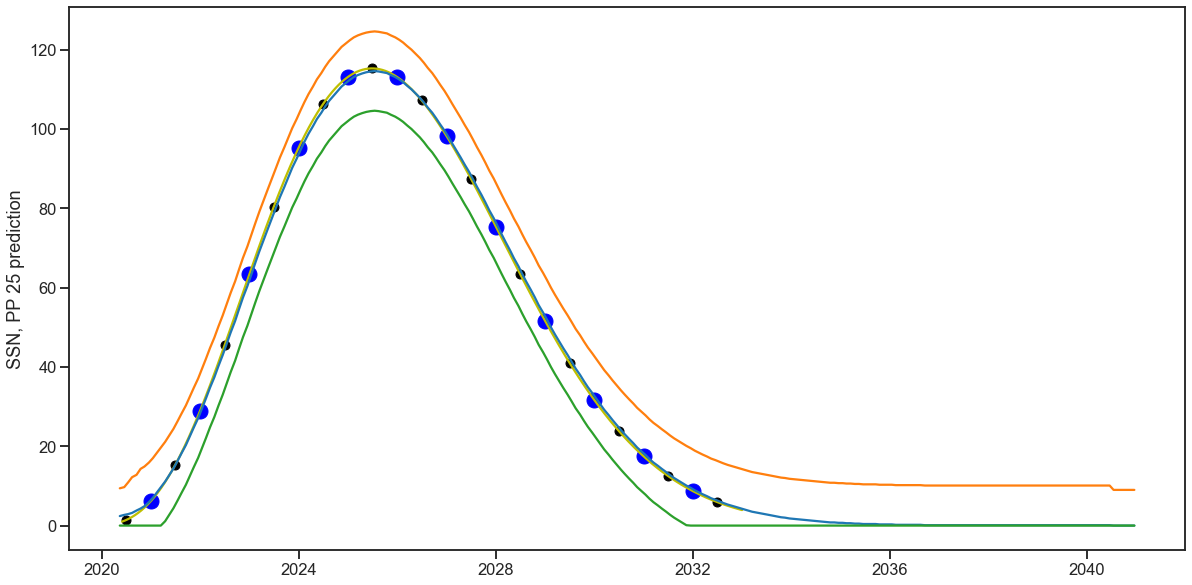

In [291]:
print('---------------------------------')
print('cycle 25')
print()

from heliocats import stats as hs
importlib.reload(hs) #reload again while debugging

############# set yearly times
last_year=2033
years_jan_1_str_25=[str(i)+'-01-01' for i in np.arange(2020,last_year) ] 
yearly_start_times_25=parse_time(years_jan_1_str_25).datetime
yearly_start_times_num_25=parse_time(years_jan_1_str_25).plot_date

#same for July 1 as middle of the year
years_jul_1_str_25=[str(i)+'-07-01' for i in np.arange(2020,last_year) ] 
yearly_mid_times_25=parse_time(years_jul_1_str_25).datetime
yearly_mid_times_num_25=parse_time(years_jul_1_str_25).plot_date

#### for smooth plotting daily list of times
#***t0 of solar cycler 25 is unclear at time of writing! assumed 2020 june 1
start_25=parse_time('2020-06-01').datetime
#not end time of next solar cycle, but end time of plotting
end_25=parse_time('2033-01-01').datetime
    
#create an array with 1 day resolution between t start and end
times_25_daily = [ start_25 + datetime.timedelta(days=n) for n in range(int ((end_25 - start_25).days))]  
times_25_daily_mat=mdates.date2num(times_25_daily) 

#*** dummy number for now
wind_mfr_number_25=[2,8,29,11,30,21,20,6,12,16,13]


print('Hathaway function models')
print('')

#make Hathaway function for solar cycle prediction

################################### Mean cycle

#hathaway 2015: t0 minus 4 months is good match
#t0 is start date of cycle
shift_t0=timedelta(days=4*30+1)

print('1. mean cycle')
#mean of all cycles Hathway 1994? 2015?
am=195
amerr=50
bm=56
cm=0.8
print('a,b,c:', am,bm,cm)



#mean of all cycles yearly and daily numbers
spots_predict_25m=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,am,bm,cm)
spots_predict_25m_daily=hs.hathaway(times_25_daily, start_25-shift_t0,am,bm,cm)

#time of maximum and ssn
print('max ssn',np.rint(np.max(spots_predict_25m_daily)))
print('at time',str(times_25_daily[np.argmax(spots_predict_25m_daily)])[0:11])


print()
print('spots yearly: ',np.rint(spots_predict_25m))

print('------')
print()










################################### SC25 panel prediction (SC25PP)
print('2. SC25 PP 2019')


#### https://www.swpc.noaa.gov/products/solar-cycle-progression - data from this plot (May 2020)
pp25_times=yearly_start_times_25[1:]
pp25_times_num=parse_time(pp25_times).plot_date
pp25_data=np.array([6.2,29.0,63.4,95.3,113.1,113.1,98.3,75.4,51.6,31.7,17.5,8.7])

#PP prediction 115.3 max in July 2025
#app=220
#apperr=50
#bpp=62
#cpp=0.8
#print('a,b,c:', app,bpp,cpp)
#spots_predict_25pp=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,app,bpp,cpp)
#spots_predict_25pp_daily=hs.hathaway(times_25_daily, start_25-shift_t0,app,bpp,cpp)
#first guess without fit
#app=220
#bpp=62
#cpp=0.8
#x0=-11*30
#print(x0,app,bpp,cpp)
#yhw=hathaway_fit(pp25_times_num-pp25_times_num[0],x0,app,bpp,cpp)

#fit with hathaway function
hw_param_pp25 = scipy.optimize.curve_fit(hathaway_fit, pp25_times_num-pp25_times_num[0],pp25_data,\
                                        p0=[-300,200,60,1])    
print('Hathaway function fit parameters x0,a,b,c:',np.round(hw_param_pp25[0][0:3],1),np.round(hw_param_pp25[0][3],2))


#get t0 date for hathway function from fit x0
x0fit_in_days=int(np.rint(hw_param_pp25[0][0]))
start_25_fit=mdates.num2date(pp25_times_num[0])+timedelta(days=x0fit_in_days)
print('t0 in SC25 PP prediction is:',start_25_fit)

spots_predict_25pp=hs.hathaway(yearly_mid_times_25,start_25_fit,hw_param_pp25[0][1],hw_param_pp25[0][2],hw_param_pp25[0][3])
spots_predict_25pp_daily=hs.hathaway(times_25_daily,start_25_fit,hw_param_pp25[0][1],hw_param_pp25[0][2],hw_param_pp25[0][3])



#spots_predict_25pp_2=hs.hathaway_fit(pp25_times_num-pp25_times_num[0],hw_param_pp25[0][0],hw_param_pp25[0][1],hw_param_pp25[0][2],hw_param_pp25[0][3])
#spots_predict_25pp_daily=hs.hathaway_fit(pp25_times_num-pp25_times_num[0],hw_param_pp25[0][0],hw_param_pp25[0][1],hw_param_pp25[0][2],hw_param_pp25[0][3])


#spots_predict_25pp=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,app,bpp,cpp)
#spots_predict_25pp_daily=hs.hathaway(times_25_daily, start_25-shift_t0,app,bpp,cpp)


#plt.plot_date(pp25_times_num,pp25_data,'ob')
#plt.plot_date(pp25_times_num,yhw,'-k')
#plt.plot(pp25_times_num,spots_predict_25pp,'-g')



#################################### 

print('or load from json')
    
print('get PP25 prediction JSON')    

#download PP25 prediction from NOAA with timestamp
#sc25pp_url='https://services.swpc.noaa.gov/json/solar-cycle/predicted-solar-cycle.json'

#try: urllib.request.urlretrieve(sc25pp_url,data_path+'predicted-solar-cycle_2020_may_27.json')
#except urllib.error.URLError as e:
#    print('Failed downloading ', sc25pp_url,' ',e)


pp25_df=pd.read_json(data_path+'predicted-solar-cycle_2020_may_27.json')

#kill first few rows and start with May 2020
pp25_df=pp25_df.drop([0,1,2,3,4,5],axis=0)
pp25_df['time-tag']
pp25_df_time=parse_time(pp25_df['time-tag']).datetime











plt.figure(12)
plt.plot_date(pp25_times,pp25_data,'ob',markersize=15)
plt.plot_date(yearly_mid_times_25,spots_predict_25pp,'ok')
plt.plot_date(times_25_daily,spots_predict_25pp_daily,'-y')

plt.plot(pp25_df_time,pp25_df['predicted_ssn'])
plt.plot(pp25_df_time,pp25_df['high_ssn'])
plt.plot(pp25_df_time,pp25_df['low_ssn'])

plt.ylabel('SSN, PP 25 prediction')




#time of maximum and ssn
print('max ssn',np.rint(np.max(spots_predict_25pp_daily)))
print('at time',str(times_25_daily[np.argmax(spots_predict_25pp_daily)])[0:11])



print()
print('spots yearly: ',np.rint(spots_predict_25pp))

print('------')
print()




pp25_df

In [292]:
################################### SC25MC
#SC25MC prediction or MC20 (see paper)


print('3. SC25 MC 2020')
a=444
aerr68=48 #MC20: 204-254 68, 153 305 95
aerr95=147 #153 305 95, +/- 76 95
b=60
c=0.8
print('a,b,c:', a,b,c)


print('start of sc25 here in MC20',start_25-shift_t0)

#yearly_numbers
spots_predict_25=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a,b,c)
#error ranges
spots_predict_25_lower68=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a-aerr68,b,c)
spots_predict_25_upper68=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a+aerr68,b,c)
spots_predict_25_lower95=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a-aerr95,b,c)
spots_predict_25_upper95=hs.hathaway(yearly_mid_times_25, start_25-shift_t0,a+aerr95,b,c)


#daily numbers
spots_predict_25_daily=hs.hathaway(times_25_daily, start_25-shift_t0,a,b,c)
#error ranges
spots_predict_25_daily_lower68=hs.hathaway(times_25_daily, start_25-shift_t0,a-aerr68,b,c)
spots_predict_25_daily_upper68=hs.hathaway(times_25_daily, start_25-shift_t0,a+aerr68,b,c)
spots_predict_25_daily_lower95=hs.hathaway(times_25_daily, start_25-shift_t0,a-aerr95,b,c)
spots_predict_25_daily_upper95=hs.hathaway(times_25_daily, start_25-shift_t0,a+aerr95,b,c)


#time of maximum and ssn
print('max ssn',np.rint(np.max(spots_predict_25_daily)))
print('at time',str(times_25_daily[np.argmax(spots_predict_25_daily)])[0:11])








print()
print('spots yearly',np.rint(spots_predict_25))

#********* add errors

#yearly spots numbers
icmes_predict_25=ssn_to_rate(spots_predict_25,linfit)[0]
icmes_predict_25_lower68=ssn_to_rate(spots_predict_25_lower68,linfit)[0]
icmes_predict_25_upper68=ssn_to_rate(spots_predict_25_upper68,linfit)[0]
icmes_predict_25_lower95=ssn_to_rate(spots_predict_25_lower95,linfit)[0]
icmes_predict_25_upper95=ssn_to_rate(spots_predict_25_upper95,linfit)[0]


#same daily
icmes_predict_25_daily=ssn_to_rate(spots_predict_25_daily,linfit)[0]
icmes_predict_25_daily_lower68=ssn_to_rate(spots_predict_25_daily_lower68,linfit)[0]
icmes_predict_25_daily_upper68=ssn_to_rate(spots_predict_25_daily_upper68,linfit)[0]
icmes_predict_25_daily_lower95=ssn_to_rate(spots_predict_25_daily_lower95,linfit)[0]
icmes_predict_25_daily_upper95=ssn_to_rate(spots_predict_25_daily_upper95,linfit)[0]



print()
print('icmes yearly: ',np.rint(icmes_predict_25))
print('icmes lower68: ',np.rint(icmes_predict_25_lower68))
print('icmes upper68: ',np.rint(icmes_predict_25_upper68))
print('icmes lower95: ',np.rint(icmes_predict_25_lower95))
print('icmes upper95: ',np.rint(icmes_predict_25_upper95))



print('------')
print()

3. SC25 MC 2020
a,b,c: 444 60 0.8
start of sc25 here in MC20 2020-02-01 00:00:00
max ssn 232.0
at time 2025-04-30 

spots yearly [  1.  35. 108. 178. 221. 232. 214. 176. 131.  87.  53.  29.  14.]

icmes yearly:  [ 8. 15. 30. 45. 54. 56. 52. 45. 35. 26. 19. 14. 11.]
icmes lower68:  [ 8. 14. 28. 41. 49. 51. 48. 41. 32. 24. 18. 13. 10.]
icmes upper68:  [ 8. 16. 33. 49. 59. 62. 57. 49. 38. 28. 20. 14. 11.]
icmes lower95:  [ 8. 13. 23. 33. 39. 40. 38. 32. 26. 20. 15. 12. 10.]
icmes upper95:  [ 8. 18. 38. 57. 69. 72. 67. 57. 44. 32. 22. 16. 12.]
------



## **Figure 3**

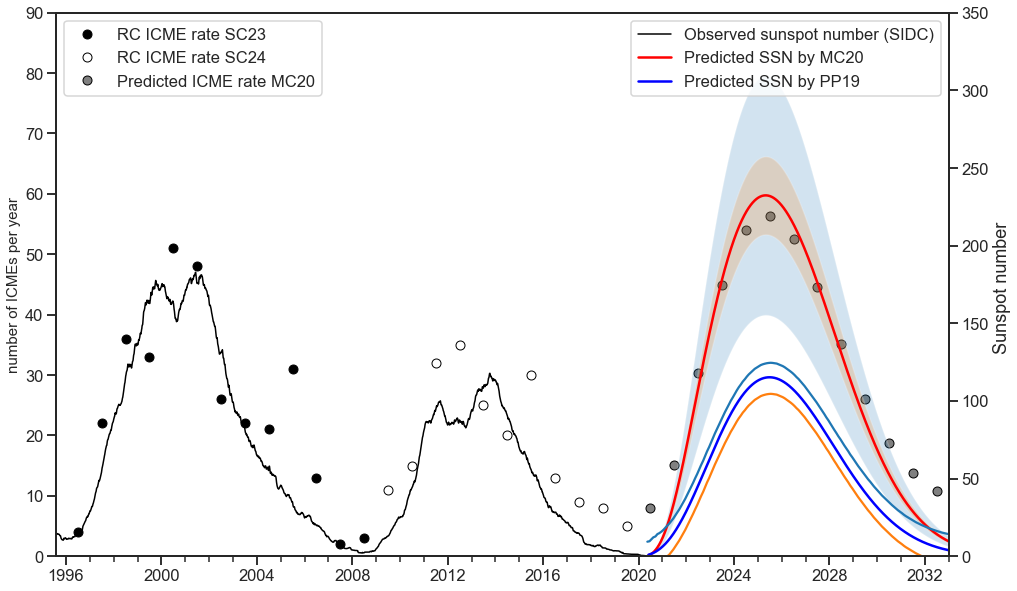

In [290]:
#cut off omni data
#otime=omni[-225000:].time
#ospot=omni[-225000:].spot
#make 12 month running mean for the hourly data
#30.42 is the average days per month
#ospot_yearly_mean=hs.running_mean(ospot,int(np.rint(24*30.42*runmean_months+1)))

#%matplotlib inline
#plt.rcParams["figure.figsize"] = (20,10)

sns.set_context("talk")     
sns.set_style('whitegrid')
sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(3,figsize=(16,10))
ax1 = plt.subplot(111) 

################################ plot various ICME rates
#ax1.plot(yearly_mid_times_23,wind_mfr_number_23, marker='s',markerfacecolor='black', alpha=0.9,label='Observed ICME rate',linestyle='')
#ax1.plot(yearly_mid_times_24,wind_mfr_number_24, marker='s',markerfacecolor='black', alpha=0.9,label='Observed ICME rate',linestyle='')

ax1.plot(yearly_mid_times_23,rc_rate23, color='black',marker='o',markerfacecolor='black',label='RC ICME rate SC23',linestyle='')
ax1.plot(yearly_mid_times_24,rc_rate24, color='black', marker='o',markerfacecolor='white',label='RC ICME rate SC24',linestyle='')
ax1.plot(yearly_mid_times_25,icmes_predict_25,color='black', marker='o',markerfacecolor='grey',label='Predicted ICME rate MC20',linestyle='')





max_spot=300
ax1.set_ylim(0,max_spot/5*1.5)
ax1.set_ylabel('number of ICMEs per year',fontsize=fsize)
ax1.legend(loc=2)
#ax2.set_yticks(fontsize=fsize) 

#old bar plot
#binweite=180
#ax2.bar(yearly_mid_times_23,wind_mfr_number_23, width=binweite,color='mediumseagreen', alpha=0.7)
#ax2.bar(yearly_mid_times_24,wind_mfr_number_24, width=binweite,color='steelblue', alpha=0.7,label='Observed ICME rate')
#ax2.bar(yearly_mid_times_25,icmes_predict_25, width=binweite,color='coral', alpha=0.7,label='Predicted ICME rate')
#ax2.set_xlim(yearly_bin_edges_23[0],yearly_bin_edges_23[-1])




#p######################## plot sunspot number 
ax2=ax1.twinx()
ax2.plot(ssn.time,ssn.spot_mean_12,'-k',alpha=1,linewidth=1.5,label='Observed sunspot number (SIDC)')


############################ #daily prediction smooth curve
ax2.plot(times_25_daily,spots_predict_25_daily,'-r',alpha=1,linewidth=2.5,label='Predicted SSN by MC20')
#ax2.plot(times_25_daily,spots_predict_25m_daily,'-g',alpha=1,linewidth=2.5,label='Predicted SSN by mean solar cycle')
ax2.fill_between(times_25_daily, spots_predict_25_daily_lower95, spots_predict_25_daily_upper95, alpha=0.2)
ax2.fill_between(times_25_daily, spots_predict_25_daily_lower68, spots_predict_25_daily_upper68, alpha=0.2)


#PP25 prediction
ax2.plot(times_25_daily,spots_predict_25pp_daily,'-b',alpha=1,linewidth=2.5,label='Predicted SSN by PP19')


#plt.plot(pp25_df_time,pp25_df['predicted_ssn'])
plt.plot(pp25_df_time,pp25_df['high_ssn'])
plt.plot(pp25_df_time,pp25_df['low_ssn'])



ax2.set_ylabel('Sunspot number ')

ax2.set_xlim(parse_time('1995-08-01').plot_date,parse_time('2033-01-01').plot_date)
max_spot=350
ax2.set_ylim(0,max_spot)
years = mdates.YearLocator()   # every year
ax2.xaxis.set_minor_locator(years)
ax2.legend(loc=1)


plt.savefig('results/plots_rate/fig3_sc25_predictions.pdf', dpi=300)
plt.savefig('results/plots_rate/fig3_sc25_predictions.png', dpi=300)

# 3 Parker Probe ICME rate prediction

### make PSP position

PSP pos
PSP conv



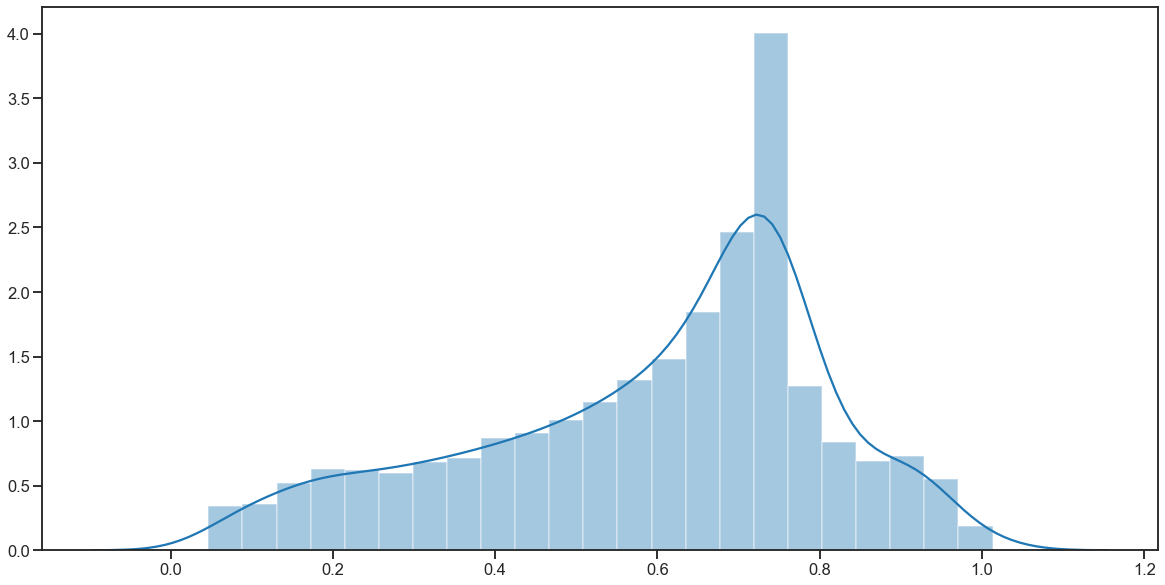

In [40]:

frame='HEEQ'
starttime =datetime.datetime(2018, 8,13)
endtime = datetime.datetime(2025, 8, 31)
psp_time = []
res_in_days=1
while starttime < endtime:
    psp_time.append(starttime)
    starttime += timedelta(days=res_in_days)
psp_time_num=mdates.date2num(psp_time)     

starttime =datetime.datetime(2018, 8,13)


spice.furnish(spicedata.get_kernel('psp_pred'))
psp=spice.Trajectory('SPP')
psp.generate_positions(psp_time,'Sun',frame)
print('PSP pos')

psp.change_units(astropy.units.AU)  
[psp_r, psp_lat, psp_lon]=hd.cart2sphere(psp.x,psp.y,psp.z)


print('PSP conv')
print()

sns.distplot(psp_r)

### Calculate expected icmes < 0.3, 0.2, 0.1 AU 

days < 0.3 AU: 334
days < 0.2 AU: 178
days < 0.1 AU: 48
ICME events in situ at PSP total mission :  142
ICME events in situ at PSP < 0.3 AU:  20
ICME events in situ at PSP < 0.2 AU:  11
ICME events in situ at PSP < 0.1 AU:  4


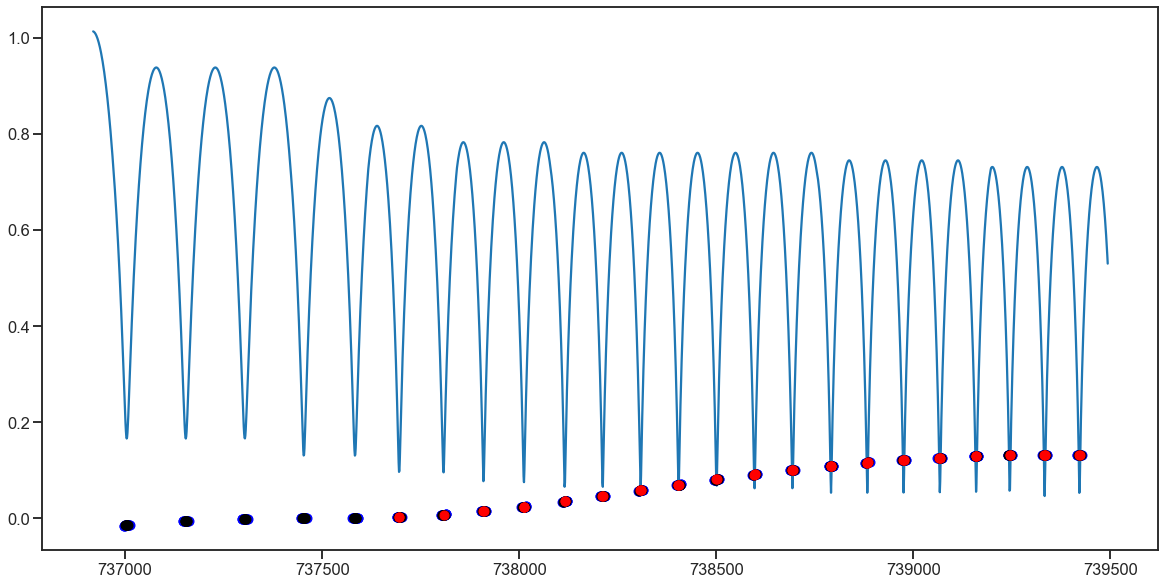

In [44]:
#positions less 0.3 AU
psp_l03=np.where(psp_r < 0.3)[0]
#positions less 0.2 AU
psp_l02=np.where(psp_r < 0.2)[0]
#positions less 0.1 AU
psp_l01=np.where(psp_r < 0.1)[0]


print('days < 0.3 AU:',psp_l03.size)
print('days < 0.2 AU:',psp_l02.size)
print('days < 0.1 AU:',psp_l01.size)



psp_time_num[psp_l03]
psp_r[psp_l03]
times_25_daily_num=mdates.date2num(times_25_daily) 
ic25=icmes_predict_25_daily/365.24


plt.plot(psp_time_num,psp_r)

#calculate icme rate again for the psp_times
conversion_factor_spots_to_icmes=4.8
icmes_psp_predict=hs.hathaway(psp_time, start_25-shift_t0,a,b,c)/conversion_factor_spots_to_icmes/365.24

plt.plot(psp_time_num[psp_l03],icmes_psp_predict[psp_l03],'ob')
plt.plot(psp_time_num[psp_l02],icmes_psp_predict[psp_l02],'ok')
plt.plot(psp_time_num[psp_l01],icmes_psp_predict[psp_l01],'or')

print('ICME events in situ at PSP total mission : ', int(np.rint(np.sum(icmes_psp_predict))))
print('ICME events in situ at PSP < 0.3 AU: ', int(np.rint(np.sum(icmes_psp_predict[psp_l03]))))
print('ICME events in situ at PSP < 0.2 AU: ', int(np.rint(np.sum(icmes_psp_predict[psp_l02]))))
print('ICME events in situ at PSP < 0.1 AU: ', int(np.rint(np.sum(icmes_psp_predict[psp_l01]))))




## **Figure 4**

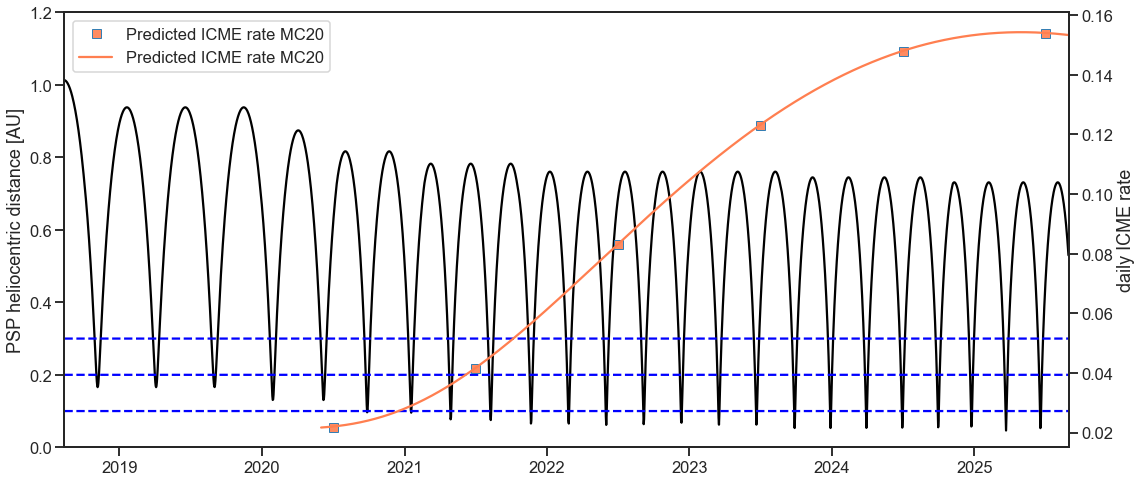

In [50]:
sns.set_context("talk")     
sns.set_style('white')
sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(4,figsize=(18,8))
ax1 = plt.subplot(111) 
ax1.plot_date(psp_time,psp_r,'-k')


ax1.plot(psp_time,np.zeros(len(psp_r))+0.3,linestyle='--',color='b')
ax1.plot(psp_time,np.zeros(len(psp_r))+0.2,linestyle='--',color='b')
ax1.plot(psp_time,np.zeros(len(psp_r))+0.1,linestyle='--',color='b')

ax1.set_ylabel('PSP heliocentric distance [AU]')
ax1.set_xlim(starttime,endtime)

ax1.set_ylim(0,1.2)


#p######################## plot sunspot number 
ax2=ax1.twinx()
#ax2.plot(ssn.time,ssn.spot_mean_12,'-k',alpha=1,linewidth=1.5,label='Observed sunspot number (SIDC)')
#ax2.plot(times_25_daily,spots_predict_25_daily,'-r',alpha=1,linewidth=2.5,label='Predicted SSN by MC20')

ax2.plot(yearly_mid_times_25,icmes_predict_25/365.24, marker='s',markerfacecolor='coral', alpha=0.9,label='Predicted ICME rate MC20',linestyle='')
ax2.plot(times_25_daily,icmes_predict_25_daily/365.24, color='coral', label='Predicted ICME rate MC20',linestyle='-')

ax2.set_ylabel('daily ICME rate')
plt.legend(loc=2)

#add observed PSP ICME rate!! corrected for times when data were taken

pspi=np.where(ic.sc_insitu=='PSP')[0]

plt.savefig('results/plots_rate/fig4_psp_rate.pdf', dpi=300)
plt.savefig('results/plots_rate/fig4_psp_rate.png', dpi=300)

# 4 3DCORE psp double

## Figure 5


In [52]:
#to do

# 5 Maybe add Dst distribution prediction and number of major geomagnetic storms

## Figure 6

(-200, 50)

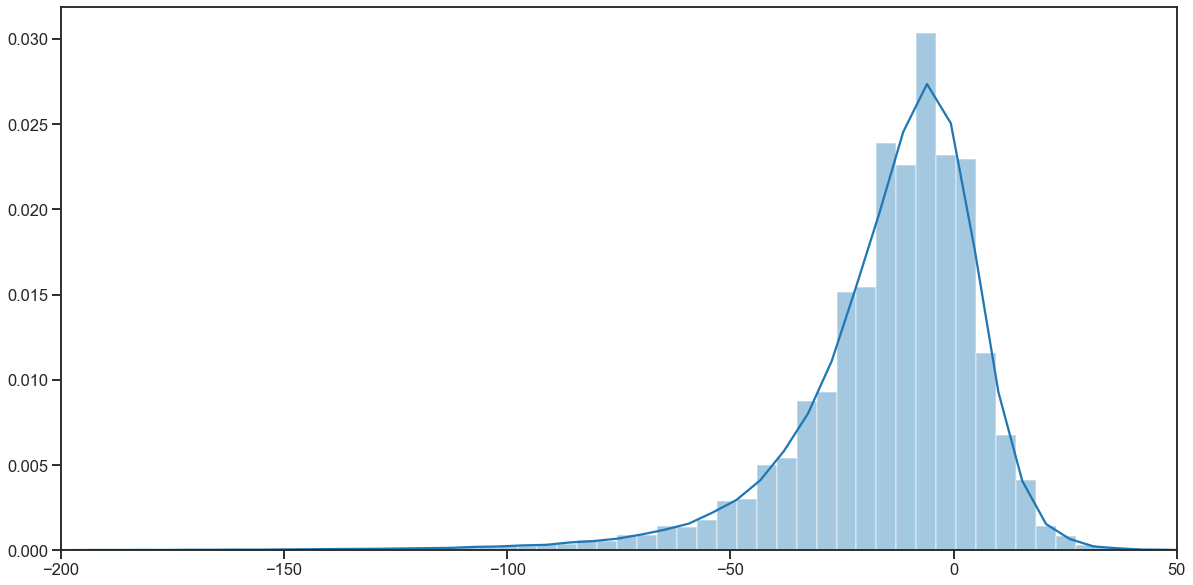

In [51]:
#distribution of sunspot number

#a=ssn.spot_mean_12.notnull()
#sns.distplot(ssn.spot_mean_12[a])

#distribution of dst for 23,24, and 25 predicted
b=np.where(np.isnan(omni.dst)==False)
sns.distplot(omni.dst[b],bins=150)
plt.xlim(-200,50)


MIT LICENSE

Copyright 2020, Christian Moestl

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
permit persons to whom the Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be included in all copies 
or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
